In [78]:
"""Evaluation of the spatial resolution from knife edge measurements."""

import os
import pandas as pd
import numpy as np
from astropy.io import fits
import re
import matplotlib.pyplot as plt 

In [ ]:
     #problem with nan and inf values in their data
    df=pd.DataFrame(data_image)
    df=df.astype(float).replace([np.inf,-np.inf],np.nan) 
    df=df.dropna()
    data_image=np.array(df)

In [51]:
def open_fits(filepath):
    """Open the file at filepath and return the data image as 2D numpy array."""
    # Fits files consist of a list of "header data units" => possible to store multiple images per file
    hdu_list = fits.open(filepath)
    # We only store one image per file
    # data grabs the image data as numpy array
    image = hdu_list[0].data
    # The convention for the origin of the image is bottom left for FITS but top left for numpy/matplotlib etc.
    # => flip the order of the rows of the array
    return image[::-1]

def  crop_to_regionofinterest(data_image, x_min, x_max, y_min, y_max):
    #crop only the top and teh bottom, change contrast to see pic
    """Crop the data_image to the given boundaries."""
    # If you don't understand the syntax below: google for 'numpy array slicing'
    # Note: numpy sees arrays as a[row, column] or a[row][column] => row corresponds to the y direction and columns are in x
    return data_image[y_min:y_max,x_min:x_max]
def move_to_xlsx(filepath,data):
    df = pd.DataFrame(data)
    filepath_pd=filepath
    df.to_excel(filepath_pd,index=False)
    
def find_nearest(array, value):
    #as the name says finds the index of the value in the array closest to a given value 
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
def modulation_transfer_function(data_image, pixel_size):
    """
    Calculate the modulation transfer function of a knife edge data image.
    
    @param data_image: 2D numpy array
    @param pixel_size: Size of a pixel in micrometer
    @return: normalized MTF, Spatial frequencies [line-pairs/mm]
    """
    number_pixels_x = data_image.shape[1]
   

    # Calculate the edge spread function
    # Hint: np.mean gives the average of the whole array, np.std the standard deviation
    esf = (data_image-np.mean(data_image))/np.std(data_image)
    
    
    # Calculate the line spread function
    # Specifying an axis for np.mean averages only over one direction (in this case along y (rows))
    # => the 2D array collapses to a 1D array
    lsf = np.gradient(
        np.mean(esf, axis=0),
        pixel_size
    )
    
     
    # Calculate the modulation transfer function
    # Hint: a nice discrete fourier transform method is np.fft.rfft()
    mtf = np.abs(np.fft.rfft(lsf))/np.max(np.abs(np.fft.rfft(lsf))) 
    
    # Calculate the spatial frequencies corresponding to the MTF values
    # pixel_size is in um therefore we need a factor 1000 to get to the common unit of line-pairs per mm
    frequencies = np.arange(len(mtf)) / (pixel_size * number_pixels_x) * 1000

    return mtf, frequencies

In [58]:
'''
Cycle trough the entire folder and save mft, frequencies in designated lists, same for spatial resolution
Also writes down the filepath
'''
folders=[]
filenames=[]
spat_res=[]
for foldername in os.listdir(r'C:\Users\patri\Documents\Uni\Fopra\FRM2\02_resolution_scans'):
    folders.append(foldername)
for foldername in folders:
    path=os.path.join(r'C:\Users\patri\Documents\Uni\Fopra\FRM2\02_resolution_scans',foldername)
    for filename in os.listdir(path):
        filenames.append(filename)
        fit=open_fits(os.path.join(path,filename))
        fit2=crop_to_regionofinterest(fit,776,1444,452,1840)
        pixel_size=33 #micrometers, TO DO check units
        mft, frequencies=modulation_transfer_function(fit2,pixel_size) 
        id_spat_res=find_nearest(mft,np.max(mft)/10) 
        spat_res.append(frequencies[id_spat_res])

In [75]:
distance=np.linspace(20,300,15)
#spatial resolution has 45 entries, 15 for each folder
spat_res_8p9=spat_res[0:15]
spat_res_17p8=spat_res[15:30]
spat_res_35p68=spat_res[30:45]

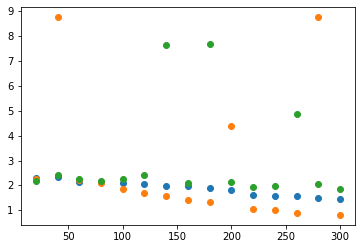

In [83]:
plt.scatter(distance,spat_res_8p9)
plt.scatter(distance,spat_res_17p8)
plt.scatter(distance,spat_res_35p68)